# Ensemble Method Analysis for Paige ML Feature

*Load in the following files:*



```
english-v1.h5                     # the model
fivegram_lexicon_all_prob.json
sixgram_lexicon_all_prob.json
newsData.txt                      # both as the test data for now
playData.txt
encoded_chars.npy                 # the np array for the lstm
```

A couple of things to note for implementation into Paige Backend:

*   The Fivegram and Sixgram models sometimes have less than 5 character-probability pairs for given input sequences. This needs to be taken into account when feeding into certain models e.g. the RFC. The way this was handled there was by adding redundant character-probability pairs either to the model or to the Fivegram/Sixgram prediction i.e. `['*', 0.0]`.


## Extension into other languages (future)

To extend this model to other languages, you need to train a **new random forest classifier** on **new fivegram and LSTM models**. See the source code from the fivegram and LSTM training folders to get the fivegram models.

Then, run all cells under heading 4: **Combining Fivegram, Sixgram and LSTM Ensemble Methods: "Combining Single LSTM and Fivegram (with Sixgram backup) with Random Forest Classifier"**.

To see how to use this as a standalone model, look at heading 6: **Implementation**.



## 0. Data Preprocessing Methods

### Methods to read in and process test data

In [ ]:
import string
import re

def read_test_data(filename):
    translator = str.maketrans('', '', string.punctuation)

    with open(filename, 'r', encoding='utf-8') as file:
        contents = [line.strip().translate(translator).lower() for line in file.readlines()]
    return ''.join(contents)


In [ ]:
def format_to_fivegram(contents):
    res = [contents[i:i+5] for i in range(len(contents)-4)]
    return res

def format_to_sixgram(contents):
    res = [contents[i:i+6] for i in range(len(contents)-5)]
    return res

def clean_text_for_lstm(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

def format_to_lstm(contents, seq_length=20):
    res = [contents[i:i+20] for i in range(len(contents)-19)]
    return res

In [ ]:
data = read_test_data('newsData.txt') # + read_test_data('playData.txt')
data[:10]
# example

'german car'

## 1. Fivegram and Sixgram

### Mounting Fivegram and Sixgram lexicons

In [ ]:
import json

with open("fivegram_lexicon_all_prob.json", "r") as file:
    fivegram_model = json.load(file)

with open("sixgram_lexicon_all_prob.json", "r") as file:
    sixgram_model = json.load(file)

### Inspecting models

In [ ]:
fivegram_model[' so ']
# checking that the probabilities are all ordered from highest to lowest

[['t', 0.175],
 ['m', 0.104],
 ['i', 0.083],
 ['p', 0.073],
 ['a', 0.068],
 ['c', 0.065],
 ['s', 0.053],
 ['f', 0.052],
 ['d', 0.044],
 ['b', 0.043],
 ['e', 0.037],
 ['r', 0.033],
 ['o', 0.032],
 ['l', 0.03],
 ['h', 0.02],
 ['w', 0.018],
 ['g', 0.017],
 ['n', 0.015],
 ['u', 0.012],
 ['v', 0.011],
 ['q', 0.006],
 ['k', 0.006],
 ['j', 0.002],
 ['y', 0.0],
 [' ', 0.0],
 ['x', 0.0],
 ['z', 0.0]]

In [ ]:
sixgram_model["*****"]

[['s', 0.159], ['a', 0.107], ['m', 0.094], ['p', 0.093], ['c', 0.087]]

### Individual Lexicons

In [ ]:
def evaluate_fivegram(text, fivegram_model, formatted = False, output_set_size=5):
    if not formatted:
        datapoints = format_to_fivegram(text)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints:
        X = sequence[:4]
        y = sequence[4]

        if X in fivegram_model:
            total_predictions += 1

            yhat = [pred[0] for pred in fivegram_model[X][:output_set_size]]
            yhat_probabilities = [pred[1] for pred in fivegram_model[X][:output_set_size]]

            if y in yhat:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    return (accuracy, total_predictions, correct_predictions)

evaluate_fivegram(
    read_test_data('playData.txt'),
    fivegram_model,
    output_set_size=5
)

(0.7989523310633839, 124085, 99138)

In [ ]:
def evaluate_sixgram(text, sixgram_model, formatted = False, output_set_size=5):
    """
    NB: there is no difference increasing the output_set_size past 5 for the sixgram, as each entry has only 5.
    """
    if not formatted:
        datapoints = format_to_sixgram(text)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints:
        X = sequence[:5]
        y = sequence[5]

        total_predictions += 1

        if X in sixgram_model:
            total_predictions += 1

            yhat = [pred[0] for pred in sixgram_model[X][:output_set_size]]
            yhat_probabilities = [pred[1] for pred in sixgram_model[X][:output_set_size]]

            if y in yhat:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    # print(f'Total predictions: {total_predictions}')

    return (accuracy, total_predictions, correct_predictions)

evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=5
)

(0.39540072078256394, 5827, 2304)

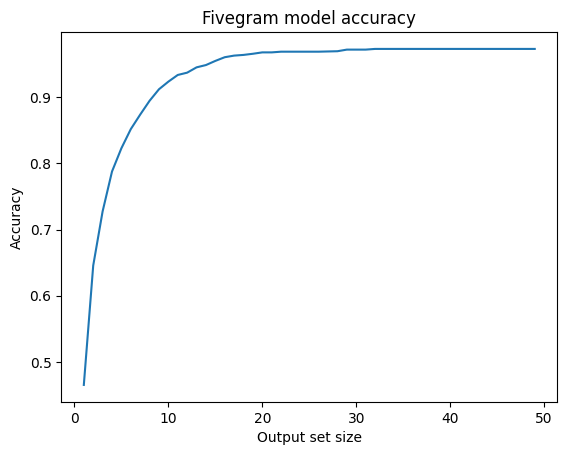

In [ ]:
import matplotlib.pyplot as plt

fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[0]) for i in range(1, 50)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

plt.plot(x_vals, y_vals_fivegram)
plt.xlabel('Output set size')
plt.ylabel('Accuracy')
plt.title('Fivegram model accuracy')
plt.show()

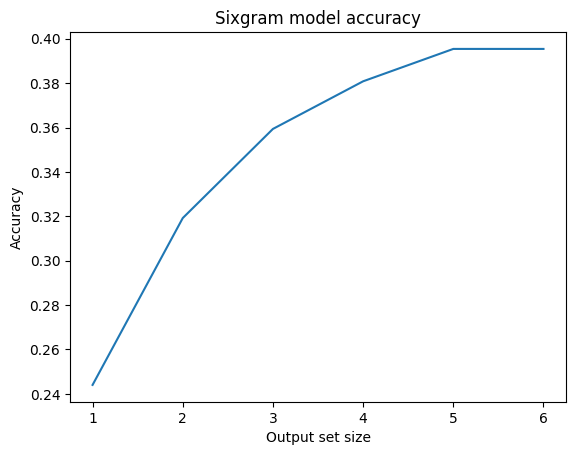

In [ ]:
sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[0]) for i in range(1, 7)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

plt.plot(x_vals, y_vals_sixgram)
plt.xlabel('Output set size')
plt.ylabel('Accuracy')
plt.title('Sixgram model accuracy')
plt.show()

### Weighted Averaging

In [ ]:
def evaluate_weighted_averaging_ensemble(
    text,
    fivegram_model,
    sixgram_model,
    output_set_size=5,
    weight_fivegram=0.5,
    weight_sixgram=0.5
):
    """
    NB: the data must NOT be formatted
    """

    # normalise weights
    total = weight_fivegram + weight_sixgram
    weight_fivegram /= total
    weight_sixgram /= total

    # format data
    datapoints = format_to_sixgram(text)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints:
        Xfivegram = sequence[1:5]
        Xsixgram = sequence[0:5]
        y = sequence[5]

        combined_probs = {}

        in_fivegram = Xfivegram in fivegram_model
        in_sixgram = Xsixgram in sixgram_model

        if not in_fivegram or in_sixgram:
            continue

        else:
            total_predictions += 1

            if in_fivegram and in_sixgram:
                data = fivegram_model[Xfivegram] + sixgram_model[Xsixgram]
                for i in range(len(data)):
                    if i < len(fivegram_model[Xfivegram]):
                        data[i].append('fivegram')
                    else:
                        data[i].append('sixgram')

            elif in_fivegram:
                data = fivegram_model[Xfivegram]
                for i in range(len(data)):
                    data[i].append('fivegram')

            else:
                data = sixgram_model[Xsixgram]
                for i in range(len(data)):
                    data[i].append('sixgram')

            for pred in data:
                if pred[0] not in combined_probs:
                    combined_probs[pred[0]] = 0

                if pred[2] == 'fivegram':
                    combined_probs[pred[0]] += weight_fivegram * pred[1]
                elif pred[2] == 'sixgram':
                    combined_probs[pred[0]] += weight_sixgram * pred[1]

            listed_probs = [(char, prob) for char, prob in combined_probs.items()]
            listed_probs = sorted(listed_probs, key=lambda x: x[1], reverse=True)

            yhat = [i[0] for i in listed_probs][:output_set_size]
            yhat_probabilities = [i[1] for i in listed_probs][:output_set_size]

            if y in yhat:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    # print(f'Total predictions: {total_predictions}')
    # print(f"Weighted Averaging Accuracy: {accuracy:.2%}")
    # print(f"Weights: Fivegram = {weight_fivegram:.2f}, Sixgram = {weight_sixgram:.2f}")

    return (accuracy, total_predictions, correct_predictions)

evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.9,
    weight_sixgram=0.3
)

(0.625, 80, 50)

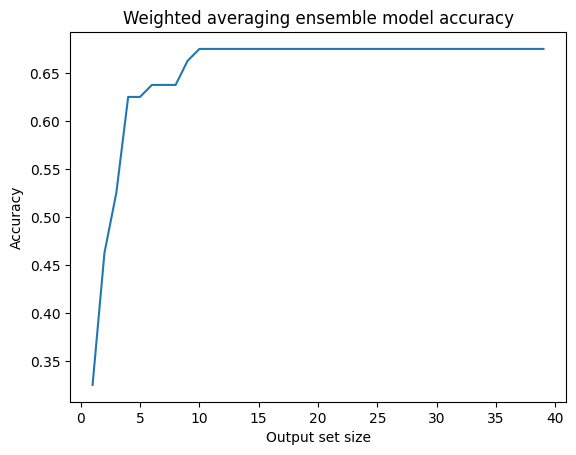

In [ ]:
weighted_averaging_ensemble_plot_data = [(i, evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.5,
    weight_sixgram=0,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_weighted_averaging_ensemble = zip(*weighted_averaging_ensemble_plot_data)

plt.plot(x_vals, y_vals_weighted_averaging_ensemble)
plt.xlabel('Output set size')
plt.ylabel('Accuracy')
plt.title('Weighted averaging ensemble model accuracy')
plt.show()

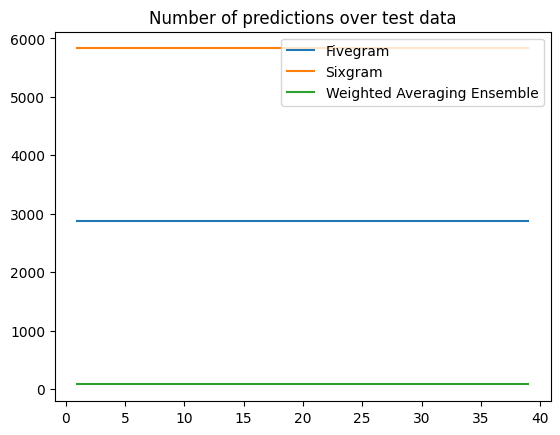

In [ ]:
fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[1]) for i in range(1, 40)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[1]) for i in range(1, 40)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

weighted_averaging_ensemble_plot_data = [(i, evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.9,
    weight_sixgram=0.3,
    output_set_size=i
)[1]) for i in range(1, 40)]

x_vals, y_vals_weighted_averaging_ensemble = zip(*weighted_averaging_ensemble_plot_data)

plt.plot(x_vals, y_vals_fivegram, label='Fivegram')
plt.plot(x_vals, y_vals_sixgram, label='Sixgram')
plt.plot(x_vals, y_vals_weighted_averaging_ensemble, label='Weighted Averaging Ensemble')
plt.legend()
plt.title("Number of predictions over test data")

plt.show()

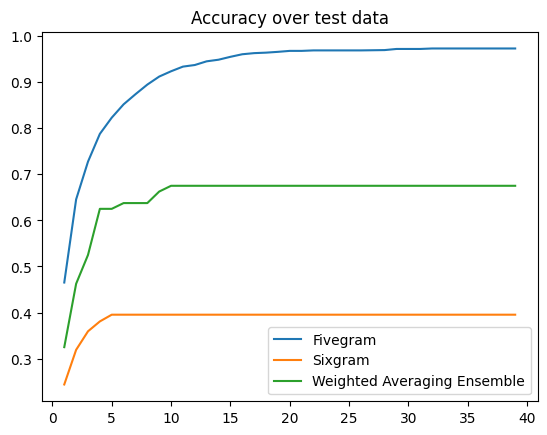

In [ ]:
fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

weighted_averaging_ensemble_plot_data = [(i, evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.9,
    weight_sixgram=0.3,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_weighted_averaging_ensemble = zip(*weighted_averaging_ensemble_plot_data)

plt.plot(x_vals, y_vals_fivegram, label='Fivegram')
plt.plot(x_vals, y_vals_sixgram, label='Sixgram')
plt.plot(x_vals, y_vals_weighted_averaging_ensemble, label='Weighted Averaging Ensemble')
plt.legend()
plt.title("Accuracy over test data")

plt.show()

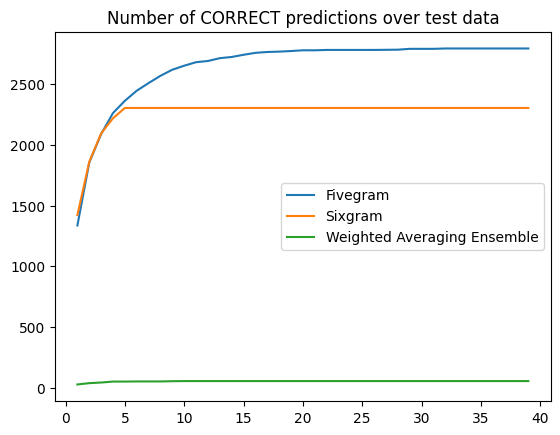

In [ ]:
fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[2]) for i in range(1, 40)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[2]) for i in range(1, 40)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

weighted_averaging_ensemble_plot_data = [(i, evaluate_weighted_averaging_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    weight_fivegram=0.9,
    weight_sixgram=0.3,
    output_set_size=i
)[2]) for i in range(1, 40)]

x_vals, y_vals_weighted_averaging_ensemble = zip(*weighted_averaging_ensemble_plot_data)

plt.plot(x_vals, y_vals_fivegram, label='Fivegram')
plt.plot(x_vals, y_vals_sixgram, label='Sixgram')
plt.plot(x_vals, y_vals_weighted_averaging_ensemble, label='Weighted Averaging Ensemble')
plt.legend()
plt.title("Number of CORRECT predictions over test data")

plt.show()

### Voting

In [ ]:
def evaluate_model_switching_ensemble(
    text,
    fivegram_model,
    sixgram_model,
    output_set_size=5
):
    """
    NB: the data must NOT be formatted
    """

    # format data
    datapoints = format_to_sixgram(text)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints:
        Xfivegram = sequence[1:5]
        Xsixgram = sequence[0:5]
        y = sequence[5]

        in_fivegram = Xfivegram in fivegram_model
        in_sixgram = Xsixgram in sixgram_model

        if not (in_fivegram or in_sixgram):
            continue

        else:
            total_predictions += 1

            if in_fivegram:

                yhat_fivegram = [pred[0] for pred in fivegram_model[Xfivegram][:output_set_size]]
                yhat_fivegram_probabilities = [pred[1] for pred in fivegram_model[Xfivegram][:output_set_size]]

            if in_sixgram:

                yhat_sixgram = [pred[0] for pred in sixgram_model[Xsixgram][:output_set_size]]
                yhat_sixgram_probabilities = [pred[1] for pred in sixgram_model[Xsixgram][:output_set_size]]

            if in_fivegram and in_sixgram:
                if yhat_fivegram_probabilities[0] >= yhat_sixgram_probabilities[0]:
                    yhat = yhat_fivegram
                    yhat_probabilities = yhat_fivegram_probabilities
                else:
                    yhat = yhat_sixgram
                    yhat_probabilities = yhat_sixgram_probabilities

            elif in_fivegram:
                yhat = yhat_fivegram
                yhat_probabilities = yhat_fivegram_probabilities

            else:
                yhat = yhat_sixgram
                yhat_probabilities = yhat_sixgram_probabilities


            if y in yhat:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    return (accuracy, total_predictions, correct_predictions)

evaluate_model_switching_ensemble(
    data,
    fivegram_model,
    sixgram_model
)

(0.8220132358063392, 2871, 2360)

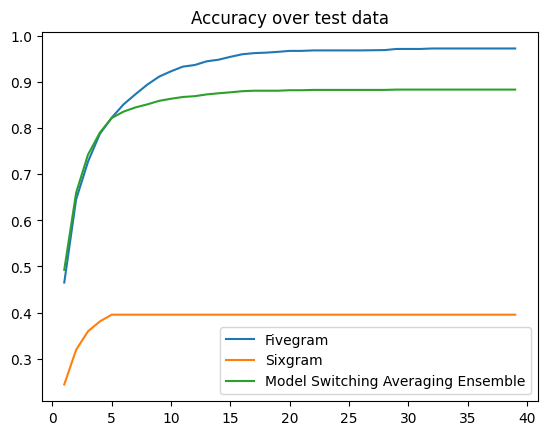

In [ ]:
fivegram_plot_data = [(i, evaluate_fivegram(
    data,
    fivegram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_fivegram = zip(*fivegram_plot_data)

sixgram_plot_data = [(i, evaluate_sixgram(
    data,
    sixgram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_sixgram = zip(*sixgram_plot_data)

model_switching_ensemble_plot_data = [(i, evaluate_model_switching_ensemble(
    data,
    fivegram_model,
    sixgram_model,
    output_set_size=i
)[0]) for i in range(1, 40)]

x_vals, y_vals_model_switching_ensemble = zip(*model_switching_ensemble_plot_data)

plt.plot(x_vals, y_vals_fivegram, label='Fivegram')
plt.plot(x_vals, y_vals_sixgram, label='Sixgram')
plt.plot(x_vals, y_vals_model_switching_ensemble, label='Model Switching Averaging Ensemble')
plt.legend()
plt.title("Accuracy over test data")

plt.show()

## 2. LSTM Only

### Mounting LSTM and required files

In [ ]:
import os
import tensorflow as tf
import numpy as np

# load lstm model
lstm_model = tf.keras.models.load_model('english-v1.h5', compile=False)
all_chars = np.load(os.path.join(os.getcwd(), 'encoded_chars.npy'))
type_chars = len(all_chars)
encoded = dict((c, i) for i, c in enumerate(all_chars))

### Aux data

In [11]:
"""aux_values.py"""

alphabet_to_dots = {
    ' ': 0,
    "a"	: 1,
    "b"	: 12,
    "c"	: 14,
    "d"	: 145,
    "e"	: 15,
    "f"	: 124,
    "g"	: 1245,
    "h"	: 125,
    "i"	: 24,
    "j"	: 245,
    "k"	: 13,
    "l"	: 123,
    "m"	: 134,
    "n"	: 1345,
    "o"	: 135,
    "p"	: 1234,
    "q"	: 12345,
    "r"	: 1235,
    "s"	: 234,
    "t"	: 2345,
    "u"	: 136,
    "v"	: 1236,
    "w"	: 2456,
    "x"	: 1346,
    "y"	: 13456,
    "z"	: 1356,
}

dots_to_alphabet = {
    0: " ",
    1: "a"	,
    12: "b"	,
    14: "c"	,
    145: "d"	,
    15: "e"	,
    124: "f"	,
    1245: "g"	,
    125: "h"	,
    24: "i"	,
    245: "j"	,
    13: "k"	,
    123: "l"	,
    134: "m"	,
    1345: "n"	,
    135: "o"	,
    1234: "p"	,
    12345: "q"	,
    1235: "r"	,
    234: "s"	,
    2345: "t"	,
    136: "u"	,
    1236: "v"	,
    2456: "w"	,
    1346: "x"	,
    13456: "y"	,
    1356: "z"	,
}

dots_to_unicode = {
    0: 0x2800,
    1: 0x2801,
    12: 0x2803,
    14: 0x2809,
    145: 0x2819,
    15: 0x2811,
    124: 0x280B,
    1245: 0x281B,
    125: 0x2813,
    24: 0x280A,
    245: 0x281A,
    13: 0x2805,
    123: 0x2807,
    134: 0x280D,
    1345: 0x281D,
    135: 0x2815,
    1234: 0x280F,
    12345: 0x281F,
    1235: 0x2817,
    234: 0x280E,
    2345: 0x281E ,
    136: 0x2825,
    1236: 0x2827,
    2456: 0x283A,
    1346: 0x282D,
    13456: 0x283D,
    1356: 0x2835,
}

unicode_to_dots = {
    0x2800: 0,
    0x2801: 1,
    0x2803: 12,
    0x2809: 14,
    0x2819: 145,
    0x2811: 15,
    0x280B: 124,
    0x281B: 1245,
    0x2813: 125,
    0x280A: 24,
    0x281A: 245,
    0x2805: 13,
    0x2807: 123,
    0x280D: 134,
    0x281D: 1345,
    0x2815: 135,
    0x280F: 1234,
    0x281F: 12345,
    0x2817: 1235,
    0x280E: 234,
    0x281E : 2345,
    0x2825: 136,
    0x2827: 1236,
    0x283A: 2456,
    0x282D: 1346,
    0x283D: 13456,
    0x2835: 1356,
}

### Aux functions

In [10]:
"""aux_functions.py"""

import re

def toBraille(c):

    engTable = {
        'a': "dots-1", 'b': "dots-12", 'c': "dots-14",
        'd': "dots-145", 'e': "dots-15", 'f': "dots-124",
        'g': "dots-1245", 'h': "dots-125", 'i': "dots-24",
        'j': "dots-245", 'k': "dots-13", 'l': "dots-123",
        'm': "dots-134", 'n': "dots-1345", 'o': "dots-135",
        'p': "dots-1234", 'q': "dots-12345", 'r': "dots-1235",
        's': "dots-234", 't': "dots-2345", 'u': "dots-136",
        'v': "dots-1236", 'w': "dots-2456", 'x': "dots-1346",
        'y': "dots-13456", 'z': "dots-1356", ' ': "space"
    }

    return engTable[c]

""" below is above as clean_text_for_lstm(), in step 0"""

# def clean_text(text):
#     cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
#     cleaned_text = cleaned_text.lower()
#     cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
#     return cleaned_text

def encode_char(c, enc):
    if c in enc:
        return enc[c]
    return enc['0']

### Predicting with LSTM

#### Implementation from API / backend

NB: for the backend implementation, the LSTM takes longer the longer input is given (not the case for fivegram and sixgram models) so take this into account during optimization.

In [ ]:
"""Implementation used in API"""

def predict_text(text, model, all_chars, type_chars, encoded):
    x = np.array([encode_char(str(dots_to_unicode[alphabet_to_dots[c]]), encoded) for c in text])
    x = x.reshape((1, len(x), 1))
    pred = model.predict(x, verbose=0)
    pred = pred.reshape(type_chars, )
    print(f"Given text: {text}")
    print(f"Raw pred: {pred}")
    argsortI = np.argsort(pred)
    print("Top 5 predicted letters")
    ret = ""
    for i in range(5):
        ind = argsortI[-i-1]
        unicode_of_pred_braille = int(all_chars[ind])
        if unicode_of_pred_braille in unicode_to_dots and unicode_to_dots[unicode_of_pred_braille] in dots_to_alphabet:
            pred_char = dots_to_alphabet[unicode_to_dots[unicode_of_pred_braille]]
        else:
            pred_char = " "
        print(f"{pred_char} : {pred[ind]}")
        ret += pred_char
        ret += ' '
        ret += toBraille(pred_char)
        ret += '\n'

    return ret

#### Implementation for testing

In [ ]:
"""Implementation here, for testing"""

def predict_text_lstm(text, model, all_chars, type_chars, encoded):
    # Encode the input text using the provided function and reshape for model input
    x = np.array([encode_char(str(dots_to_unicode[alphabet_to_dots[c]]), encoded) for c in text])
    x = x.reshape((1, len(x), 1))

    # Make predictions using the LSTM model
    pred = model.predict(x, verbose=0)

    # Reshape the predictions to a one-dimensional array
    pred = pred.reshape(type_chars, )

    # Print the input text and raw predictions
    # print(f"Given text: {text}")
    # print(f"Raw pred: {pred}")

    # Get the indices that would sort the predictions in ascending order
    argsortI = np.argsort(pred)

    # Print the top 5 predicted letters along with their probabilities
    # print("Top 5 predicted letters")

    # Initialize an empty list to store character-probability pairs
    predictions_list = []

    # Loop through the top 5 predictions
    for i in range(5):
        ind = argsortI[-i-1]
        unicode_of_pred_braille = int(all_chars[ind])

        # Convert Unicode to corresponding character using provided mappings
        if unicode_of_pred_braille in unicode_to_dots and unicode_to_dots[unicode_of_pred_braille] in dots_to_alphabet:
            pred_char = dots_to_alphabet[unicode_to_dots[unicode_of_pred_braille]]
        else:
            pred_char = " "

        # Print the character and its probability
        # print(f"{pred_char} : {pred[ind]}")

        # Append character and probability to the list
        predictions_list.append([pred_char, pred[ind]])

    # Return the list of character-probability pairs
    return predictions_list

In [ ]:
cleaned_text = clean_text_for_lstm(data)[:61]

pred = predict_text_lstm("german carmaker pors", lstm_model, all_chars, type_chars, encoded)

print(f"Actual char: '{cleaned_text[60]}'")
print(pred)

Actual char: ' '
[['o', 0.4513739], ['s', 0.19037889], [' ', 0.11792756], ['i', 0.06689991], ['e', 0.05461567]]


### Adding temperature for variation

A temperature of:
- 1: will not have an effect on the data
- \>1: will make the output more diverse but may reduce accuracy
- <1: will make the output more focused, but can reduce diversity

In [ ]:
import math

def sample_with_temperature(predicted, temperature=1.0):
    sum_before = sum([a[1] for a in predicted])
    temp = []
    result = []
    sum_after = 0

    for char, prob in predicted:
        prob = math.log(prob) / temperature
        exp_prob = math.exp(prob)

        temp.append([char, exp_prob])
        sum_after += exp_prob

    for char, prob in temp:
        prob /= sum_after
        prob *= sum_before
        result.append([char, prob])

    return sorted(result, key=lambda x: x[1], reverse=True)

print(f"Before temperature: {pred}")
print(f"After temperature: {sample_with_temperature(pred, temperature=1.3)}")

Before temperature: [['o', 0.4513739], ['s', 0.19037889], [' ', 0.11792756], ['i', 0.06689991], ['e', 0.05461567]]
After temperature: [['o', 0.3834400948372615], ['s', 0.19737826375473305], [' ', 0.1365515539257544], ['i', 0.08829170424796141], ['e', 0.07553431586101389]]


### Evaluating LSTM

In [ ]:
def evaluate_single_lstm(text, lstm_model, all_chars, type_chars, encoded, input_seq_length = 20, output_set_size=5, temperature=1.0, sample_size=-1):
    text = clean_text_for_lstm(text)
    datapoints = format_to_lstm(text, seq_length=input_seq_length)

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints[:sample_size]:
        X = sequence[:input_seq_length-1]
        y = sequence[input_seq_length-1]

        pred = predict_text_lstm(X, lstm_model, all_chars, type_chars, encoded)
        pred = sample_with_temperature(pred, temperature)

        total_predictions += 1

        yhat = [i[0] for i in pred]
        yhat_probabilities = [i[1] for i in pred]

        if y in yhat:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    print(f'Length {input_seq_length} done')

    return (accuracy, total_predictions, correct_predictions)


evaluate_single_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    sample_size=1000,
    input_seq_length=5
)

Length 5 done


(0.713, 1000, 713)

In [ ]:
single_lstm_plot_data = [(i, evaluate_single_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    input_seq_length=i
)[0]) for i in range(5, 21)]

x_vals, y_vals_single_lstm = zip(*single_lstm_plot_data)

import matplotlib.pyplot as plt

plt.plot(x_vals, y_vals_single_lstm)
plt.xlabel('Input string size')
plt.ylabel('Accuracy')
plt.title('Single LSTM model Accuracy')
plt.show()

KeyboardInterrupt: 

## 3. Multiple LSTMs

### Test with two learners of varying input sequence length

In [ ]:
def evaluate_multiple_lstm(text, lstm_model, all_chars, type_chars, encoded, input_seq_lengths = [5, 12], output_set_size=5, temperature=1.0, sample_size=-1):
    text = clean_text_for_lstm(text)
    datapoints = format_to_lstm(text, seq_length=max(input_seq_lengths))

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints[:sample_size]:
        Xs = [sequence[-1*l:-1] for l in input_seq_lengths]
        y = sequence[-1]

        preds = [predict_text_lstm(Xs[i], lstm_model, all_chars, type_chars, encoded) for i in range(len(Xs))]
        preds = [sample_with_temperature(preds[i], temperature) for i in range(len(Xs))]

        new_pred = []
        for pred in preds:
            new_pred += pred

        new_pred = sorted(new_pred, key=lambda x: x[1], reverse=True)
        pred = []
        checked_chars = set()

        for p in new_pred:
            if p[0] in checked_chars:
                pass
            else:
                checked_chars.add(p[0])
                pred.append(p)

        total_predictions += 1

        yhat = [i[0] for i in pred]
        yhat_probabilities = [i[1] for i in pred]

        if y in yhat:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    print(f'Lengths {input_seq_lengths} done')

    return (accuracy, total_predictions, correct_predictions)

# evaluate_multiple_lstm(
#     data,
#     lstm_model,
#     all_chars,
#     type_chars,
#     encoded,
#     sample_size=100
# )

### Further analysis

Lengths [5, 10, 15] done
Lengths [5, 10, 16] done
Lengths [5, 10, 17] done
Lengths [5, 10, 18] done
Lengths [5, 10, 19] done
Lengths [5, 10, 20] done


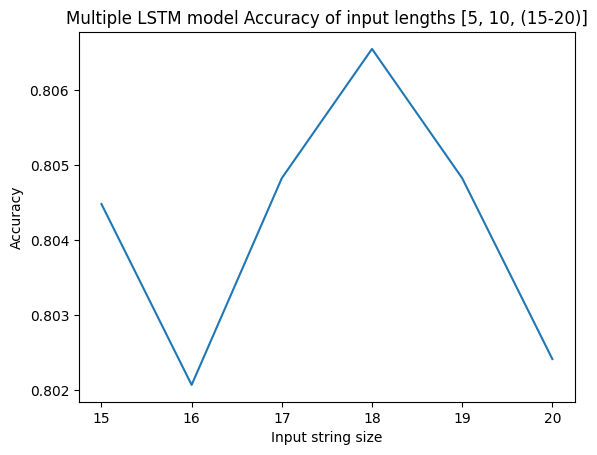

In [ ]:
multiple_lstm_plot_data = [(i, evaluate_multiple_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    input_seq_lengths=[5, 10, i]
)[0]) for i in range(15, 21)]

x_vals, y_vals_multiple_lstm = zip(*multiple_lstm_plot_data)

plt.plot(x_vals, y_vals_multiple_lstm)
plt.xlabel('Input string size')
plt.ylabel('Accuracy')
plt.title('Multiple LSTM model Accuracy of input lengths [5, 10, (15-20)]')
plt.show()

Lengths [5, 10] done
Lengths [5, 11] done
Lengths [5, 12] done
Lengths [5, 13] done
Lengths [5, 14] done
Lengths [5, 15] done
Lengths [5, 16] done
Lengths [5, 17] done
Lengths [5, 18] done
Lengths [5, 19] done
Lengths [5, 20] done


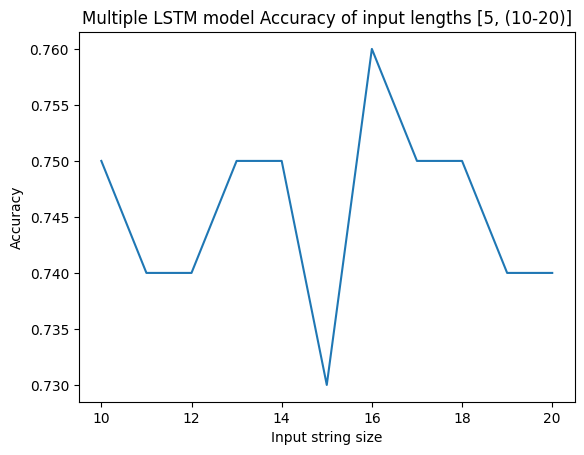

In [ ]:
multiple_lstm_plot_data = [(i, evaluate_multiple_lstm(
    data,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    sample_size=100,
    input_seq_lengths=[5, i]
)[0]) for i in range(10, 21)]

x_vals, y_vals_multiple_lstm = zip(*multiple_lstm_plot_data)

plt.plot(x_vals, y_vals_multiple_lstm)
plt.xlabel('Input string size')
plt.ylabel('Accuracy')
plt.title('Multiple LSTM model Accuracy of input lengths [5, (10-20)]')
plt.show()

## 4. Combining Fivegram, Sixgram and Ensemble LSTM methods

### Voting between Fivegram and Optimal LSTM

In [ ]:
def evaluate_voting_between_lstms_fivegram_ensemble(
    text,
    fivegram_model,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    input_seq_lengths_lstm = [5, 10, 18], # this was optimal from testing above
    output_set_size=5,
    temperature=1.0,
    sample_size=-1
):
    """
    NB: the data must NOT be formatted
    """

    # format data
    text = clean_text_for_lstm(text)
    datapoints = format_to_lstm(text, seq_length=max(input_seq_lengths_lstm))

    correct_predictions = 0
    total_predictions = 0

    for sequence in datapoints[:sample_size]:
        Xfivegram = sequence[-5:-1]
        Xlstms = [sequence[-1*l:-1] for l in input_seq_lengths_lstm]
        y = sequence[-1]

        in_fivegram = Xfivegram in fivegram_model

        # fivegram predictions

        if in_fivegram:

            yhat_fivegram = [pred[0] for pred in fivegram_model[Xfivegram][:output_set_size]]
            yhat_fivegram_probabilities = [pred[1] for pred in fivegram_model[Xfivegram][:output_set_size]]


        # multiple lstm predictions

        preds = [predict_text_lstm(Xlstms[i], lstm_model, all_chars, type_chars, encoded) for i in range(len(Xlstms))]
        preds = [sample_with_temperature(preds[i], temperature) for i in range(len(Xlstms))]

        new_pred = []
        for pred in preds:
            new_pred += pred

        new_pred = sorted(new_pred, key=lambda x: x[1], reverse=True)
        pred = []
        checked_chars = set()

        for p in new_pred:
            if p[0] in checked_chars:
                pass
            else:
                checked_chars.add(p[0])
                pred.append(p)

        yhat_multiple_lstm = [i[0] for i in pred]
        yhat_multiple_lstm_probabilities = [i[1] for i in pred]


        # combining the two for an ensemble method

        total_predictions += 1

        # only combine if fivegram exists
        if in_fivegram:
            yhat_zipped = list(zip(yhat_multiple_lstm, yhat_multiple_lstm_probabilities)) + list(zip(yhat_fivegram, yhat_fivegram_probabilities))
            yhat_dict = {}
            for char, prob in yhat_zipped:
                if char in yhat_dict:
                    yhat_dict[char] = max(prob, yhat_dict[char])
                else:
                    yhat_dict[char] = prob

            yhat = sorted(
                [[char, prob] for char, prob in yhat_dict.items()],
                key=lambda x: x[1],
                reverse=True
            )[:output_set_size]

            yhat_probabilities = [prob for _, prob in yhat]
            yhat = [char for char, _ in yhat]

            if y in yhat:
                correct_predictions += 1

        else:
            if y in yhat_multiple_lstm:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    return (accuracy, total_predictions, correct_predictions)




# evaluate_voting_between_lstms_fivegram_ensemble(
#     data,
#     fivegram_model,
#     lstm_model,
#     all_chars,
#     type_chars,
#     encoded,
#     temperature = 0.8,
#     sample_size=200
# )


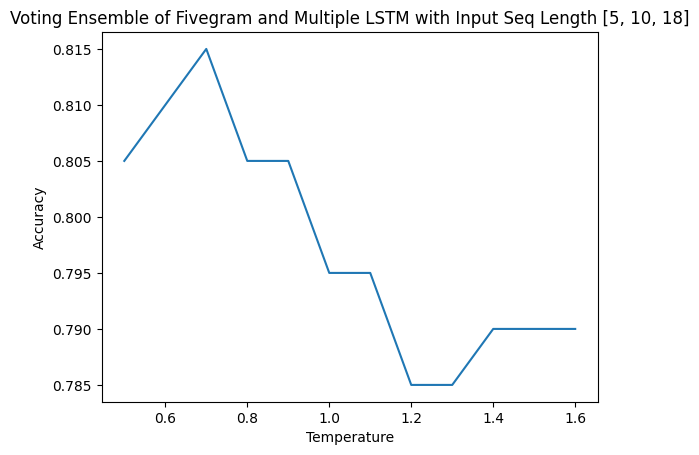

In [ ]:
voting_between_lstms_fivegram_ensemble_plot_data = [(i, evaluate_voting_between_lstms_fivegram_ensemble(
    data,
    fivegram_model,
    lstm_model,
    all_chars,
    type_chars,
    encoded,
    temperature=i,
    sample_size=200
)[0]) for i in np.arange(0.5, 1.6, 0.1)]

x_vals, y_vals_voting_between_lstms_fivegram_ensemble = zip(*voting_between_lstms_fivegram_ensemble_plot_data)

plt.plot(x_vals, y_vals_voting_between_lstms_fivegram_ensemble)
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Voting Ensemble of Fivegram and Multiple LSTM with Input Seq Length [5, 10, 18]')
plt.show()

### Combining Single LSTM and Fivegram (with Sixgram backup) with Random Forest Classifier



#### Loading in Test Data

In [ ]:
# LOADING IN TEST DATA

rfc_data = clean_text_for_lstm(read_test_data("flores_eng.txt"))[50008:53000] + read_test_data("playData.txt")[:3000] + read_test_data("newsData.txt")[:3000]
rfc_data[:100], len(rfc_data)

('time passed many words that were borrowed from german coalesced this was the beginning of enlightenm',
 8992)

#### Fixing Fivegram Model outputs

In [ ]:
# CLEANING FIVEGRAM MODEL: there is a thing where in the inner most lists, the list is more than 2 long e.g. [' tha']

for sequence, probs in fivegram_model.items():
    # each probs is a list of lists
    # Remember that the fivegram does not have 5 chars all the time
    new_probs = []
    for prob in probs:
        t = prob[:2]
        new_probs.append(t)
    if len(new_probs) < 5:
        for _ in range(5 - len(new_probs)):
            new_probs.append(['*', 0.0])

    fivegram_model[sequence] = new_probs

fivegram_model['good']

[[' ', 0.931],
 ['s', 0.053],
 ['n', 0.006],
 ['i', 0.003],
 ['b', 0.002],
 ['w', 0.002],
 ['l', 0.001],
 ['y', 0.0],
 ['e', 0.0],
 ['q', 0.0],
 ['t', 0.0],
 ['f', 0.0],
 ['o', 0.0],
 ['h', 0.0],
 ['p', 0.0],
 ['v', 0.0],
 ['c', 0.0],
 ['g', 0.0],
 ['a', 0.0],
 ['m', 0.0]]

#### Defining functions to predict given Fivegram and single LSTM

In [ ]:
# DEFINING FUNCTION TO PREDICT GIVEN TEXT AND FIVEGRAM

def format_and_predict_text_fivegram(texts, model, seq_length=20, output_length=5):
    all_predictions = []
    all_texts = []

    for text in format_to_lstm(clean_text_for_lstm(texts), seq_length):
        all_texts.append((text[:-1], text[-1]))
        X = text[:-1]
        y = text[-1]

        if X[-4:] in model:
            yhat = model[X[-4:]]

        all_predictions.append(yhat[:output_length])

    return all_texts, all_predictions

# format_and_predict_text_fivegram(
#     "Hello world this is an interesting example of a sentence that i thou",
#     fivegram_model
# )

In [ ]:
# DEFINING FUNCTION TO PREDICT GIVEN TEXT AND SINGLE LSTM (INCLUDING TEMPERATURE)

def format_and_predict_text_lstm(texts, model, all_chars, type_chars, encoded, temperature=1.0, seq_length=20):
    # Initialize an empty list to store predictions for each input text
    all_predictions = []
    all_texts = []

    # Loop through each input text in the list
    for text in format_to_lstm(clean_text_for_lstm(texts), seq_length=seq_length):
        all_texts.append((text[:-1], text[-1]))

        # Encode the input text using the provided function and reshape for model input
        x = np.array([encode_char(str(dots_to_unicode[alphabet_to_dots[c]]), encoded) for c in text[:-1]])
        x = x.reshape((1, len(x), 1))

        # Make predictions using the LSTM model
        pred = model.predict(x, verbose=0)

        # Reshape the predictions to a one-dimensional array
        pred = pred.reshape(type_chars, )

        # Get the indices that would sort the predictions in ascending order
        argsortI = np.argsort(pred)

        # Initialize an empty list to store character-probability pairs for the current text
        predictions_list = []

        # Loop through the top 5 predictions
        for i in range(5):
            ind = argsortI[-i-1]
            unicode_of_pred_braille = int(all_chars[ind])

            # Convert Unicode to corresponding character using provided mappings
            if unicode_of_pred_braille in unicode_to_dots and unicode_to_dots[unicode_of_pred_braille] in dots_to_alphabet:
                pred_char = dots_to_alphabet[unicode_to_dots[unicode_of_pred_braille]]
            else:
                pred_char = " "

            # Append character and probability to the list
            predictions_list.append([pred_char, pred[ind]])

        # Append the list of predictions for the current text to the overall list
        all_predictions.append(sample_with_temperature(predictions_list, temperature=temperature))

    # Return the list of lists of character-probability pairs for each input text
    return all_texts, all_predictions

# format_and_predict_text_lstm(
#     "Hello world this is an interesting example of a sentence that i thou",
#     lstm_model,
#     all_chars,
#     type_chars,
#     encoded,
#     temperature=1.3
# )

#### Combining models' results in a "feature matrix"

In [ ]:
# FUNCTION TO CREATE A MATRIX OF RESULTS

import numpy as np

def create_feature_matrix(text, lstm_model, fivegram_model, all_chars, type_chars, encoded, input_seq_length=20):
    # Obtain predictions from LSTM and Fivegram models

    lstm_texts, lstm_predictions = format_and_predict_text_lstm(text, lstm_model, all_chars, type_chars, encoded, temperature=1.2, seq_length=input_seq_length)
    fivegram_texts, fivegram_predictions = format_and_predict_text_fivegram(text, fivegram_model, seq_length=input_seq_length)

    # Combine the LSTM and Fivegram predictions into a single feature matrix
    feature_matrix = []

    for lstm_text, lstm_preds in zip(lstm_texts, lstm_predictions):
        # Assuming lstm_text and fivegram_text are the same, modify if needed
        fivegram_preds = next(preds for fivegram_text, preds in zip(fivegram_texts, fivegram_predictions) if fivegram_text == lstm_text)

        # Extract relevant information
        input_sequence = lstm_text[0]
        actual_next_char = lstm_text[1]
        lstm_top_predictions = lstm_preds[:5]  # Take the top 5 predictions
        fivegram_top_predictions = fivegram_preds[:5]  # Take the top 5 predictions

        # Construct a feature vector
        feature_vector = [[input_sequence], [actual_next_char]] + [lstm_top_predictions] + [fivegram_top_predictions]

        # Append the feature vector to the feature matrix
        feature_matrix.append(feature_vector)

    for entry in feature_matrix:
        fivegram_preds = entry[3]
        temp = []
        for pred in fivegram_preds:
            temp.append(pred[:2])
        entry[3] = temp

    return feature_matrix

# feature_matrix = create_feature_matrix(
#     data[:100],
#     lstm_model,
#     fivegram_model,
#     all_chars,
#     type_chars,
#     encoded
# )

# feature_matrix

#### Defining functions to generate features and labels given "feature matrix"

In [ ]:
# FUNCTION TO GENERATE FEATURES GIVEN FEATURE MATRIX

def generate_features(feature_matrix):
    X = []

    for entry in feature_matrix:
        input_seq = entry[0][0]
        next_char = entry[1][0]
        lstm_probs = entry[2]
        fivegram_probs = entry[3]

        x = []

        for char, prob in lstm_probs:
            # x.append(1 if char==next_char else 0)
            x.append(prob)
            x.append(0)

        for char, prob in fivegram_probs:
            # x.append(1 if char==next_char else 0)
            x.append(prob)
            x.append(1)

        X.append(x)

    return X

# features = generate_features(feature_matrix)
# features

In [ ]:
# FUNCTION TO GENERATE LABELS GIVEN

import random

def generate_labels(feature_matrix):
    y = []
    uncertainties = 0

    for entry in feature_matrix:
        input_seq = entry[0][0]
        next_char = entry[1][0]
        lstm_probs = entry[2]
        fivegram_probs = entry[3]

        lstm_prob = 0
        fivegram_prob = 0

        for char, prob in lstm_probs:
            if char == next_char:
                lstm_prob = prob
        for char, prob in fivegram_probs:
            if char == next_char:
                fivegram_prob = prob

        if lstm_prob > fivegram_prob:
            y.append(0)
        elif lstm_prob < fivegram_prob:
            y.append(1)
        else:
            y.append(-1) # if the probabilities of the models are the same or
            uncertainties += 1

    # define confidence as the proportion of uncertain decisions
    confidence = 1 - (uncertainties / len(y))

    return y, confidence

# labels, confidence = generate_labels(feature_matrix)
# labels

#### Checking shape of features and labels (exploration)

In [ ]:
# checking to see if there are 5 probabilities per model every time

a, b = 0, 0

for feature in feature_matrix:
    if len(feature[2]) != 5:
        print(feature[2])
        print(len(feature[2]), 0)
        a += 1
    if len(feature[3]) != 5:
        print(feature[3])
        print(len(feature[3]), 1)
        b += 1

(a, b)

(0, 0)

In [ ]:
# checking to see the shape of features and labels

for feature in features:
    if len(feature) != 30:
        print(len(feature))

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

#### Training and testing the RFC

In [ ]:
# TRAINING AND TESTING THE RFC MODEL

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: getting the data
feature_matrix = create_feature_matrix(rfc_data[:1000], lstm_model, fivegram_model, all_chars, type_chars, encoded, input_seq_length=5)
features = generate_features(feature_matrix)
labels, confidence = generate_labels(feature_matrix)

X = np.array(features)
y = np.array(labels)

# Step 2: Training and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Evaluation
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.6598984771573604
Classification Report:
               precision    recall  f1-score   support

          -1       0.41      0.27      0.33        26
           0       0.59      0.31      0.41        51
           1       0.70      0.89      0.78       120

    accuracy                           0.66       197
   macro avg       0.57      0.49      0.51       197
weighted avg       0.63      0.66      0.63       197



In [ ]:
clf.predict([[0.9723375061721946, 0, 0.017613715847433438, 0, 0.00365688969602145, 0, 0.0030220930849054785, 0, 0.0019894125116602726, 0, 0.945, 1, 0.041, 1, 0.014, 1, 0.0, 1, 0.0, 1]])

array([0])

#### Evaluating RFC of Single LSTM and Fivegram

In [ ]:
def evaluate_rfc_with_single_lstm_fivegram(
        text,
        fivegram_model,
        lstm_model,
        rfc_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=10,
        temperature=1.0,
        sample_size=-1
):
    # format data
    text = clean_text_for_lstm(text)

    correct_predictions = 0
    total_predictions = 0

    data = text[:sample_size]

    feature_matrix = create_feature_matrix(text, lstm_model, fivegram_model, all_chars, type_chars, encoded, input_seq_length=input_seq_length)
    features = generate_features(feature_matrix)
    labels, confidence = generate_labels(feature_matrix)

    X = np.array(features)
    # y = np.array(labels)

    model_choices = clf.predict(X)
    # accuracy = accuracy_score(y, y_pred)

    # upto this point the rfc has produced a list of which model to use, 0 is LSTM, 1 is fivegram and 2 is random

    for i in range(len(model_choices)):
        choice = model_choices[i]
        total_predictions += 1

        if choice == -1 or choice == 0:
            # default to lstm if uncertain
            entry = feature_matrix[i]
            input_seq = entry[0][0]
            next_char = entry[1][0]
            lstm_predictions = entry[2]

            yhat, yhat_probabilities = [], []

            for char, prob in lstm_predictions:
                yhat.append(char)
                yhat_probabilities.append(prob)

            y = next_char

            if y in yhat:
                correct_predictions += 1

        elif choice == 1:
            # fivegram choice
            entry = feature_matrix[i]
            input_seq = entry[0][0]
            next_char = entry[1][0]
            fivegram_predictions = entry[3]

            yhat, yhat_probabilities = [], []

            for char, prob in fivegram_predictions:
                yhat.append(char)
                yhat_probabilities.append(prob)

            y = next_char

            if y in yhat:
                correct_predictions += 1


    accuracy = correct_predictions / total_predictions

    return (accuracy, total_predictions, correct_predictions)


evaluate_rfc_with_single_lstm_fivegram(
        data[:200],
        fivegram_model,
        lstm_model,
        clf,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=1.0,
        sample_size=-1
)

(0.8491620111731844, 179, 152)

## 5. Final Testing

### Getting results for charts

In [ ]:
"""bar chart"""

data = read_test_data('flores_eng.txt')[20000:22000]

categories = [
    "Fivegram",
    "Sixgram",
    "Weighted Average of Fivegram and Sixgram (3:1)",
    "Voting between Fivegram and Sixgram",
    "Single LSTM of Input Length 5",
    "Single LSTM of Input Length 5 with 0.8 Temperature",
    "Single LSTM of Input Length 5 with 1.2 Temperature",
    "Single LSTM of Input Length 5 with 1.5 Temperature",
    "Multiple LSTMs of Input Lengths [5, 20]",
    "Multiple LSTMs of Input Lengths [5, 10, 18]",
    "Voting Ensemble of Fivegram and Multiple LSTM [5, 10, 18] with temperature 0.8",
    "RFC of Single LSTM of Input Length 5 and temperature 0.8 and Fivegram"
]

fivegram_eval = evaluate_fivegram(
        data,
        fivegram_model
    )
sixgram_eval = evaluate_sixgram(
        data,
        sixgram_model
    )
weighted_averaging_ensemble_eval = evaluate_weighted_averaging_ensemble(
        data,
        fivegram_model,
        sixgram_model,
        weight_fivegram=0.9,
        weight_sixgram=0.3
    )
model_switching_ensemble_eval = evaluate_model_switching_ensemble(
        data,
        fivegram_model,
        sixgram_model
    )
single_lstm_ensemble_eval = evaluate_single_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=1.0,
        sample_size=500
    )
single_lstm_low_temp_ensemble_eval = evaluate_single_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=0.8,
        sample_size=500
    )
single_lstm_high_temp_ensemble_eval = evaluate_single_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=1.2,
        sample_size=500
    )
single_lstm_higher_temp_ensemble_eval =evaluate_single_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=1.5,
        sample_size=500
    )
multiple_two_lstm_ensemble_eval = evaluate_multiple_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_lengths=[5, 20],
        sample_size=500
    )
multiple_three_lstm_ensemble_eval = evaluate_multiple_lstm(
        data,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        input_seq_lengths=[5, 10, 18],
        sample_size=500
    )
voting_between_lstms_fivegram_ensemble_eval = evaluate_voting_between_lstms_fivegram_ensemble(
        data,
        fivegram_model,
        lstm_model,
        all_chars,
        type_chars,
        encoded,
        temperature = 0.8,
        sample_size=500
    )
rfc_with_single_lstm_fivegram_ensemble_eval = evaluate_rfc_with_single_lstm_fivegram(
        data,
        fivegram_model,
        lstm_model,
        clf,
        all_chars,
        type_chars,
        encoded,
        input_seq_length=5,
        temperature=0.8,
    )



# all output set sizes are 5 as a control variable for the use case of the API
results = [
    fivegram_eval,
    sixgram_eval,
    weighted_averaging_ensemble_eval,
    model_switching_ensemble_eval,
    single_lstm_ensemble_eval,
    single_lstm_low_temp_ensemble_eval,
    single_lstm_high_temp_ensemble_eval,
    single_lstm_higher_temp_ensemble_eval,
    multiple_two_lstm_ensemble_eval,
    multiple_three_lstm_ensemble_eval,
    voting_between_lstms_fivegram_ensemble_eval,
    rfc_with_single_lstm_fivegram_ensemble_eval
]


# results = [
#     evaluate_fivegram(
#         data,
#         fivegram_model
#     ),
#     evaluate_sixgram(
#         data,
#         sixgram_model
#     ),
#     evaluate_weighted_averaging_ensemble(
#         data,
#         fivegram_model,
#         sixgram_model,
#         weight_fivegram=0.9,
#         weight_sixgram=0.3
#     ),
#     evaluate_model_switching_ensemble(
#         data,
#         fivegram_model,
#         sixgram_model
#     ),
#     evaluate_single_lstm(
#         data,
#         lstm_model,
#         all_chars,
#         type_chars,
#         encoded,
#         input_seq_length=5,
#         temperature=1.0,
#         sample_size=500
#     ),
#     evaluate_single_lstm(
#         data,
#         lstm_model,
#         all_chars,
#         type_chars,
#         encoded,
#         input_seq_length=5,
#         temperature=0.8,
#         sample_size=500
#     ),evaluate_single_lstm(
#         data,
#         lstm_model,
#         all_chars,
#         type_chars,
#         encoded,
#         input_seq_length=5,
#         temperature=1.2,
#         sample_size=500
#     ),evaluate_single_lstm(
#         data,
#         lstm_model,
#         all_chars,
#         type_chars,
#         encoded,
#         input_seq_length=5,
#         temperature=1.5,
#         sample_size=500
#     ),
#     evaluate_multiple_lstm(
#         data,
#         lstm_model,
#         all_chars,
#         type_chars,
#         encoded,
#         input_seq_lengths=[5, 20],
#         sample_size=500
#     ),
#     evaluate_multiple_lstm(
#         data,
#         lstm_model,
#         all_chars,
#         type_chars,
#         encoded,
#         input_seq_lengths=[5, 10, 18],
#         sample_size=500
#     ),
#     evaluate_voting_between_lstms_fivegram_ensemble(
#         data,
#         fivegram_model,
#         lstm_model,
#         all_chars,
#         type_chars,
#         encoded,
#         temperature = 0.8,
#         sample_size=500
#     ),
#     evaluate_rfc_with_single_lstm_fivegram(
#         data,
#         fivegram_model,
#         lstm_model,
#         clf,
#         all_chars,
#         type_chars,
#         encoded,
#         input_seq_length=5,
#         temperature=0.8,
#     )
# ]

Length 5 done
Length 5 done
Length 5 done
Length 5 done
Lengths [5, 20] done
Lengths [5, 10, 18] done


### Sorting accuracies and displaying

[0.8372093023255814, 0.42570993914807304, 0.4642857142857143, 0.8517956499747091, 0.75, 0.75, 0.75, 0.75, 0.82, 0.836, 0.838, 0.8226141078838174]
['Fivegram', 'Sixgram', 'Weighted Average of Fivegram and Sixgram (3:1)', 'Voting between Fivegram and Sixgram', 'Single LSTM of Input Length 5', 'Single LSTM of Input Length 5 with 0.8 Temperature', 'Single LSTM of Input Length 5 with 1.2 Temperature', 'Single LSTM of Input Length 5 with 1.5 Temperature', 'Multiple LSTMs of Input Lengths [5, 20]', 'Multiple LSTMs of Input Lengths [5, 10, 18]', 'Voting Ensemble of Fivegram and Multiple LSTM [5, 10, 18] with temperature 0.8', 'RFC of Single LSTM of Input Length 5 and temperature 0.8 and Fivegram']


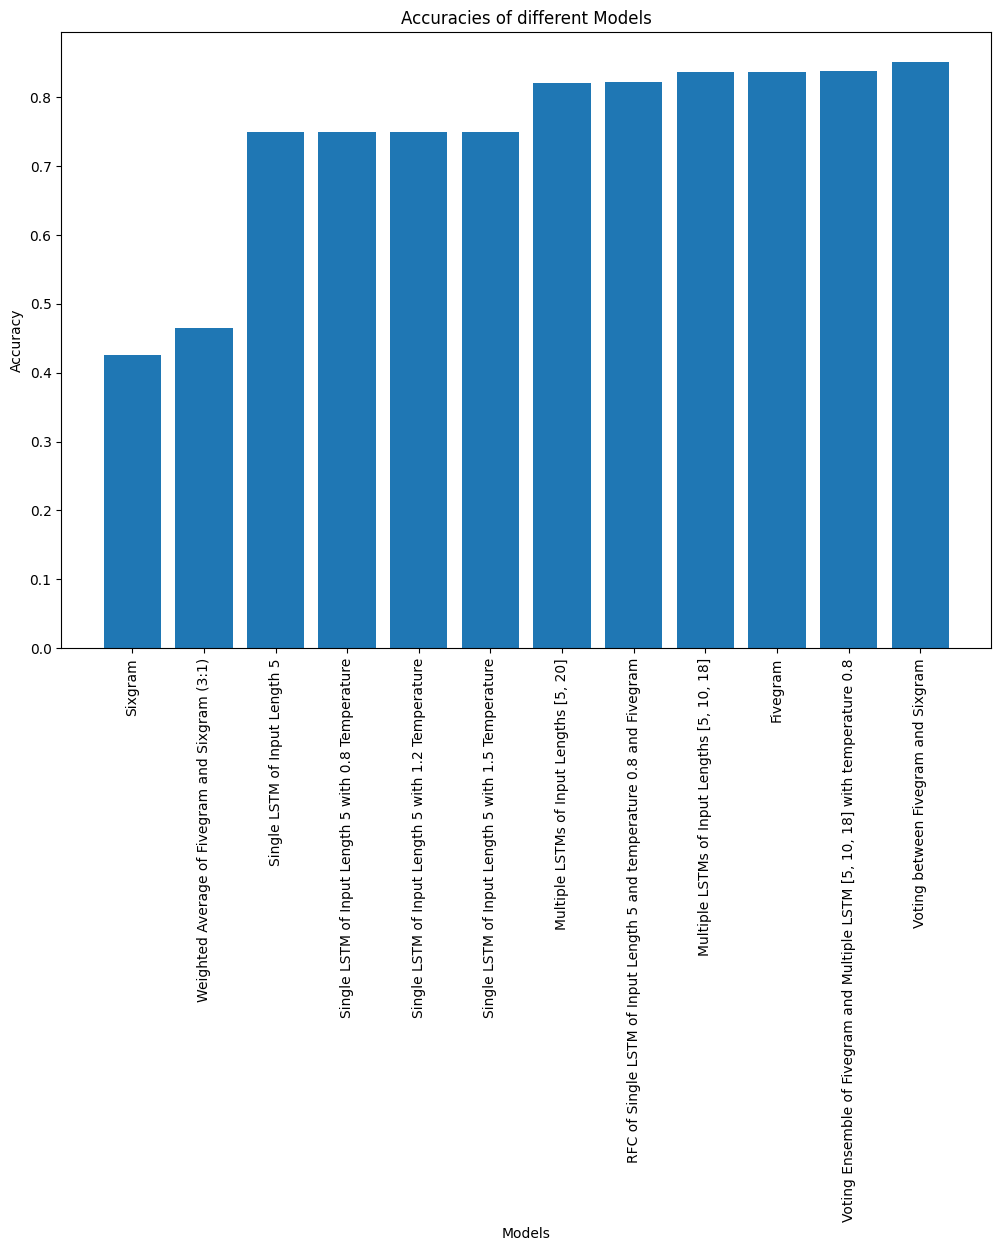

In [ ]:
import matplotlib.pyplot as plt

model_accuracies = [result[0] for result in results]
print(model_accuracies)
model_total_predictions = [result[1] for result in results]
print(categories)
model_correct_predictions = [result[2] for result in results]

accuracy_pairs = sorted(
    list(zip(categories, model_accuracies)),
    key=lambda x: x[1],
    reverse=False
)

sorted_accuracies = [pair[1] for pair in accuracy_pairs]
sorted_categories = [pair[0] for pair in accuracy_pairs]

plt.figure(figsize=(12,8))
plt.bar(sorted_categories, sorted_accuracies)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracies of different Models")
plt.xticks(rotation=90)
plt.show()

### Displaying total and correct predictions

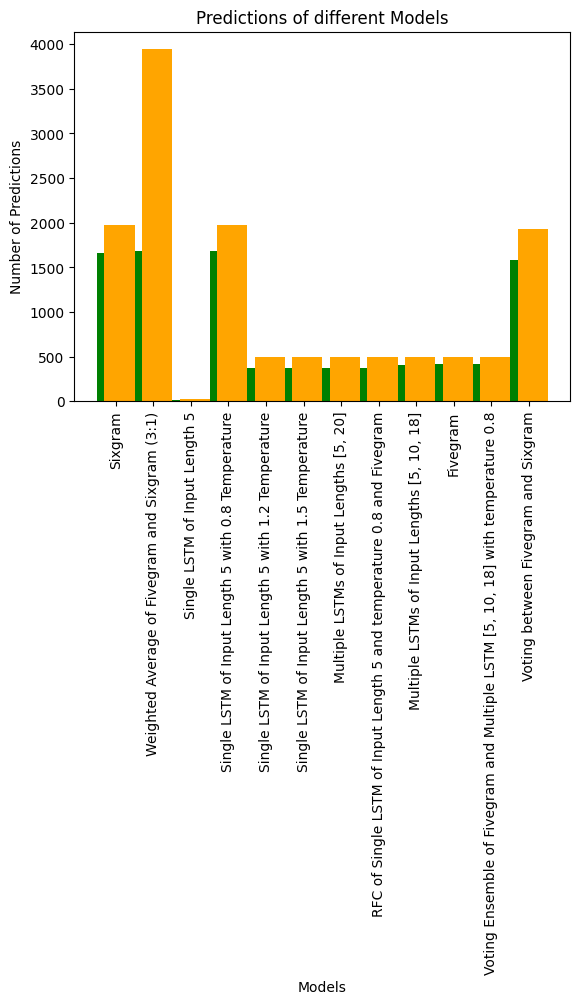

In [ ]:
bar_width = 0.2

correct_positions = np.arange(len(sorted_categories))
total_positions = correct_positions + bar_width


plt.bar(correct_positions, model_correct_predictions, label="Correct Predictions", color="green")
plt.bar(total_positions, model_total_predictions, label="Total Predictions", color="orange")
plt.xlabel("Models")
plt.ylabel("Number of Predictions")
plt.title("Predictions of different Models")
plt.xticks(correct_positions + bar_width / 2, sorted_categories, rotation=90)
plt.show()

## 6. Implementation ***(LOOK HERE IF YOU ARE IMPLEMENTING RFC INTO BACKEND)***

### Exporting the previous trained RFC (from above)

In [1]:
# EXPORTING MODEL

import pickle

with open('rfc_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

NameError: name 'clf' is not defined

### Load all models and files listed in title (plus rfc)

In [5]:
# ATTEMPTING TO LOAD MODELS AND AUX DATA

import json
import pickle
import os
import tensorflow as tf
import numpy as np

with open("fivegram_lexicon_all_prob.json", "r") as file:
    fivegram_model = json.load(file)

with open('rfc_model.pkl', 'rb') as file:
    rfc_model = pickle.load(file)

lstm_model = tf.keras.models.load_model('english-v1.h5', compile=False)
all_chars = np.load(os.path.join(os.getcwd(), 'encoded_chars.npy'))
type_chars = len(all_chars)
encoded = dict((c, i) for i, c in enumerate(all_chars))

### Functions to define fivegram and LSTM predictions

In [6]:
def predict_with_fivegram(text, fivegram_prob_model, placeholder_prediction=['*', 0.0]):
    """
    Make a prediction for the next character on a single sequence string, using a fivegram model.

    Return an array of arrays, where each subarray is a pair of predicted character and probability.
    """

    if len(text) < 4:
        padding = "*" * (4 - len(text))
        X = padding + text
    else:
        X = text[-4:]

    if X in fivegram_prob_model:

        y = fivegram_prob_model[X]

        if len(y) < 5:
            for _ in range(5 - len(y)):
                y.append(placeholder_prediction)

        y = y[:5] # taking top 5 predictions
        result = []

        # some of the fivegram output subarrays have 'fivegram' appended to them many times e.g. see output for ' tha'
        # this code asserts that the subarrays of the result are pairs
        for pair in y:
            newpair = pair[:2]
            result.append(newpair)

        return result

    else:
        return None

def predict_with_lstm(
    text,
    model,
    all_chars,
    type_chars,
    encoded,
    input_seq_len
):
    """
    Make a prediction for the next character on a single sequence string, using a single LSTM.

    Return an array of arrays, where each subarray is a pair of predicted character and probability.
    """

    # Get the correct length of input sequence, this is important when training on LSTMs of different input sequence length to capture different contexts
    if len(text) > input_seq_len:
        text = text[-1*input_seq_len:]
    elif len(text) == input_seq_len:
        pass
    else:
        padding = " " * (input_seq_len - len(text))
        text = padding + text

    x = np.array([encode_char(str(dots_to_unicode[alphabet_to_dots[c]]), encoded) for c in text])
    x = x.reshape((1, len(x), 1))

    pred = model.predict(x, verbose=0)
    pred = pred.reshape(type_chars, )

    argsortI = np.argsort(pred)

    # Initialize an empty list to store character-probability pairs
    predictions_list = []

    # Loop through the top 5 predictions
    for i in range(5):
        ind = argsortI[-i-1]
        unicode_of_pred_braille = int(all_chars[ind])

        # Convert Unicode to corresponding character using provided mappings
        if unicode_of_pred_braille in unicode_to_dots and unicode_to_dots[unicode_of_pred_braille] in dots_to_alphabet:
            pred_char = dots_to_alphabet[unicode_to_dots[unicode_of_pred_braille]]
        else:
            pred_char = " "

        # Append character and probability to the list
        predictions_list.append([pred_char, pred[ind]])

    # Return the list of character-probability pairs
    return predictions_list

def sample_with_temperature(predicted, temperature=1.0):
    """
    Take a given list of prediction pairs (of character-probability subarrays), and add temperature to the sample.

    A temperature of:

    1: will not have an effect on the data
    >1: will make the output more diverse but may reduce accuracy
    <1: will make the output more focused, but can reduce diversity
    """

    sum_before = sum([a[1] for a in predicted])
    temp = []
    result = []
    sum_after = 0

    for char, prob in predicted:
        prob = math.log(prob) / temperature
        exp_prob = math.exp(prob)

        temp.append([char, exp_prob])
        sum_after += exp_prob

    for char, prob in temp:
        prob /= sum_after
        prob *= sum_before
        result.append([char, prob])

    return sorted(result, key=lambda x: x[1], reverse=True)

### Function to predict text (the important function)

In [7]:
def predict_text(
    text,
    rfc_model,
    lstm_model,
    fivegram_prob_model,
    all_chars,
    type_chars,
    encoded,
    lstm_input_seq_len=5,
    temperature=1.0
):
    """
    Make a prediction for the next character on a single sequence string, and choose the model based on inputting both the LSTM and fivegram outputs into a Random Forest Classifier to decide which model outputs to use.

    If no fivegram prediction is available to ensemble, then default to the LSTM output.

    Return an array of arrays, where each subarray is a pair of predicted character and probability.
    """

    text = clean_text(text)

    lstm_predictions = sample_with_temperature(predict_with_lstm(text, lstm_model, all_chars, type_chars, encoded, lstm_input_seq_len), temperature=temperature)
    fivegram_predictions = predict_with_fivegram(text, fivegram_prob_model=fivegram_prob_model)

    """
    The shape of the input to the RFC is a NumPy array of length 20 subarrays, where every 2 consecutive values represent:
    - the probability of the guess
    - 0 for if the guess was made by the LSTM model, 1 for if it was made by the fivegram model, and -1 if uncertain (default to LSTM)
    """

    if fivegram_predictions is None:
        return lstm_predictions

    else:
        X = []
        for char, prob in lstm_predictions:
            X.append(prob)
            X.append(0)
        for char, prob in fivegram_predictions:
            X.append(prob)
            X.append(1)
        X = np.array([X])

        rfc_pred = rfc_model.predict(X)

        if rfc_pred[0] < 1:
            return lstm_predictions
        else:
            return strip_fivegram_predictions_of_placeholders(fivegram_predictions)

def strip_fivegram_predictions_of_placeholders(fivegram_predictions):
    """
    Fivegram predictions may have ['*', 0.0] predictions in them to fill up to 5 guesses for the RFC model to correctly be able to give predictions.

    This function removes all pairs to get the output ready to send back to the front-end.
    """

    r = []
    for char, prob in fivegram_predictions:
        if char != '*':
            r.append([char, prob])
    return r

def clean_text(text):
    """
    This function is the same as can be found in aux_functions.py, but removes support for numeric characters as this is not supported in the fivegram model, so it won't be in the RFC.
    """

    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

### Showcasing function use

In [14]:
import re
import math

predict_text(
    "Hellow",
    rfc_model,
    lstm_model,
    fivegram_model,
    all_chars,
    type_chars,
    encoded,
    lstm_input_seq_len=10,
    temperature=0.8
)

[[' ', 0.456], ['s', 0.275], ['i', 0.173], ['e', 0.056], ['a', 0.019]]

In [1]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.3
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.0
bigframes==0.21.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.42
branca==0.7.1
build==1.0.3
CacheControl==0.14.0
cachetools==5.3.2
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.85
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.1
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.3
cufflinks==0.17.3
cupy-cuda12x==12.2.0
